In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt

from chroma.db.clickhouse import Clickhouse
from chroma.db.index.hnswlib import Hnswlib
from chroma.config import Settings
from chroma.algorithms.core_algorithms import *

In [9]:
chroma_settings = Settings()
db = Clickhouse(chroma_settings)
model_space = "default_scope"

training_dataset_name = "waymo-phx-train-hc"
unlabeled_dataset_name = "waymo-sf-val-hc"

training_data = db.fetch(
    where={"model_space": model_space, "dataset": training_dataset_name}
)
unlabeled_data = db.fetch(
    where={"model_space": model_space, "dataset": unlabeled_dataset_name}
)

ann_index = Hnswlib(chroma_settings)

ann_index.run(
    model_space=model_space,
    uuids=training_data["uuid"].tolist(),
    embeddings=training_data["embedding"].tolist(),
    num_threads=8
)

time to fetch 1677402 embeddings:  8.621602058410645
time to fetch 205777 embeddings:  0.9389340877532959


# Activation Uncertainty

In [10]:
activation_uncertainty_percentiles = activation_uncertainty(training_data=training_data, unlabeled_data=unlabeled_data)

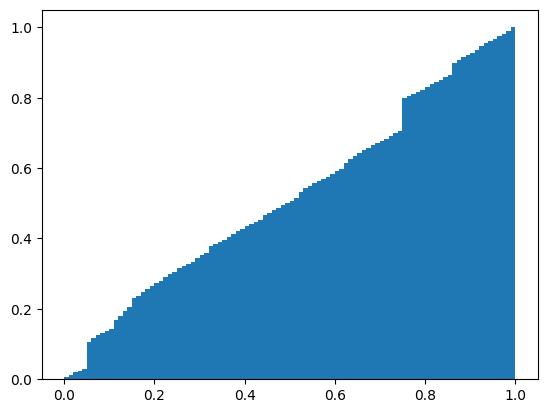

In [11]:
# Plot a histogram of the activation uncertainty percentiles
import matplotlib.pyplot as plt
plt.hist(activation_uncertainty_percentiles, bins=100, density=True, cumulative=True)
plt.show()

# Boundary Uncertainty

In [15]:
boundary_uncertainties = boundary_uncertainty(training_data=training_data, unlabeled_data=unlabeled_data, ann_index=ann_index, n_neighbors=100)

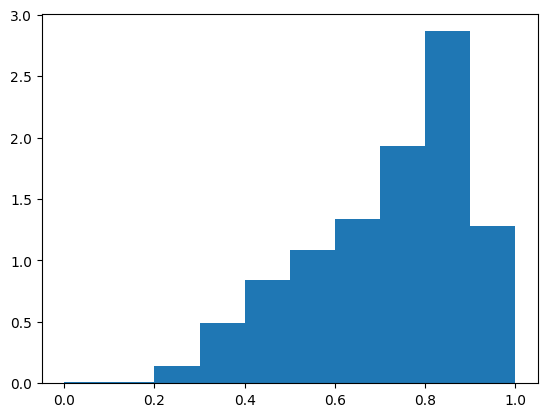

In [16]:
# Plot a histogram of the boundary uncertainty percentiles
plt.hist(boundary_uncertainties, bins=10, density=True)
plt.show()

# Cluster Outliers

In [17]:
representative_cluster_percentiles, difficult_cluster_percentiles = cluster_outliers(training_data=training_data, unlabeled_data=unlabeled_data)

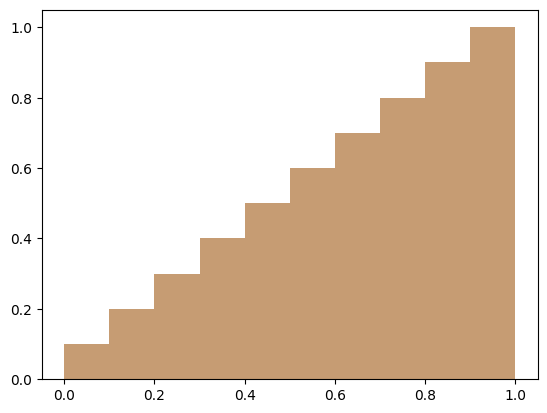

In [18]:
# Plot the representative and difficult cluster outlier percentiles, on the same plot
plt.hist(representative_cluster_percentiles, bins=10, density=True, cumulative=True, alpha=0.5)
plt.hist(difficult_cluster_percentiles, bins=10, density=True, cumulative=True, alpha=0.5)
plt.show()

# Class Outliers [Not Yet Functioning]

Filtering the ANN index causes the connectivity graph to become disconnected, so nearest neighbors aren't found. 
The proximal solution is to create class-wise indices per dataset. These could be created dynamically.
The long term solution is to modify hnsw so that it takes this kind of partitioning into account, when it's known in advance.

Some more ideas: https://blog.vasnetsov.com/posts/categorical-hnsw/

In [18]:
representative_class_outliers, difficult_class_outliers = class_outliers(training_data=training_data, inference_data=unlabeled_data, ann_index=ann_index, n_neighbors=10)

RuntimeError: Cannot return the results in a contigious 2D array. Probably ef or M is too small

In [ ]:
# Plot histograms of the representative and difficult class outlier scores, on the same plot
plt.hist(representative_class_outliers, bins=100, density=True, cumulative=True, alpha=0.5)
plt.hist(difficult_class_outliers, bins=100, density=True, cumulative=True, alpha=0.5)
plt.show()